In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tkinter import *
from tkinter import ttk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [28]:
frameobjtrain = {'img' : [], 'mask' : []}


In [3]:
def processdata( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0])
        
    return frameObj

In [4]:
frameobjtrain = processdata(frameobjtrain,imgPath = 'C:/Users/DELL/Downloads/train',maskPath = 'C:/Users/DELL/Downloads/train')

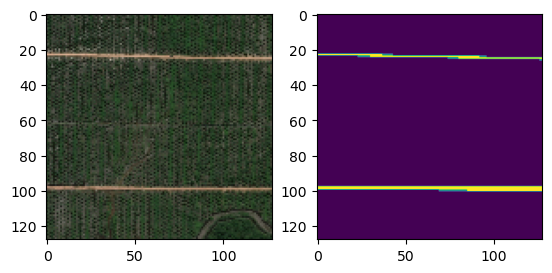

In [34]:
plt.subplot(1,2,1)
plt.imshow(frameobjtrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(frameobjtrain['mask'][1])
plt.show()

In [5]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model
from keras import backend as K

def IoU(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value


def IoU_loss(y_true, y_pred):
    return -IoU(y_true, y_pred)


In [6]:
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = [IoU_loss], metrics = ['accuracy', IoU])

In [7]:
checkpointpath="trained/cp.ckpt"
path=os.path.dirname(checkpointpath)
call_back=tf.keras.callbacks.ModelCheckpoint(checkpointpath,save_weights_only=True,verbose=1)

In [14]:
retVal = unet.fit(np.array(frameobjtrain['img']), np.array(frameobjtrain['mask']), epochs = 40, verbose = 1,callbacks=[call_back])

Epoch 1/40
195/195 [==============================] - ETA: 0s - loss: -0.3781 - accuracy: 0.9580 - IoU: 0.3782
Epoch 1: saving model to trained\cp.ckpt
195/195 [==============================] - 663s 3s/step - loss: -0.3781 - accuracy: 0.9580 - IoU: 0.3782
Epoch 2/40
195/195 [==============================] - ETA: 0s - loss: -0.3862 - accuracy: 0.9589 - IoU: 0.3861
Epoch 2: saving model to trained\cp.ckpt
195/195 [==============================] - 650s 3s/step - loss: -0.3862 - accuracy: 0.9589 - IoU: 0.3861
Epoch 3/40
195/195 [==============================] - ETA: 0s - loss: -0.3938 - accuracy: 0.9596 - IoU: 0.3939
Epoch 3: saving model to trained\cp.ckpt
195/195 [==============================] - 638s 3s/step - loss: -0.3938 - accuracy: 0.9596 - IoU: 0.3939
Epoch 4/40
195/195 [==============================] - ETA: 0s - loss: -0.3990 - accuracy: 0.9601 - IoU: 0.3991
Epoch 4: saving model to trained\cp.ckpt
195/195 [==============================] - 637s 3s/step - loss: -0.3990 - acc

Epoch 33/40
195/195 [==============================] - ETA: 0s - loss: -0.5018 - accuracy: 0.9683 - IoU: 0.5016
Epoch 33: saving model to trained\cp.ckpt
195/195 [==============================] - 631s 3s/step - loss: -0.5018 - accuracy: 0.9683 - IoU: 0.5016
Epoch 34/40
195/195 [==============================] - ETA: 0s - loss: -0.5029 - accuracy: 0.9686 - IoU: 0.5030
Epoch 34: saving model to trained\cp.ckpt
195/195 [==============================] - 631s 3s/step - loss: -0.5029 - accuracy: 0.9686 - IoU: 0.5030
Epoch 35/40
195/195 [==============================] - ETA: 0s - loss: -0.5048 - accuracy: 0.9686 - IoU: 0.5046
Epoch 35: saving model to trained\cp.ckpt
195/195 [==============================] - 631s 3s/step - loss: -0.5048 - accuracy: 0.9686 - IoU: 0.5046
Epoch 36/40
195/195 [==============================] - ETA: 0s - loss: -0.5099 - accuracy: 0.9690 - IoU: 0.5098
Epoch 36: saving model to trained\cp.ckpt
195/195 [==============================] - 635s 3s/step - loss: -0.50

In [8]:
unet.load_weights(checkpointpath)

Text(0.5, 0, 'epochs')

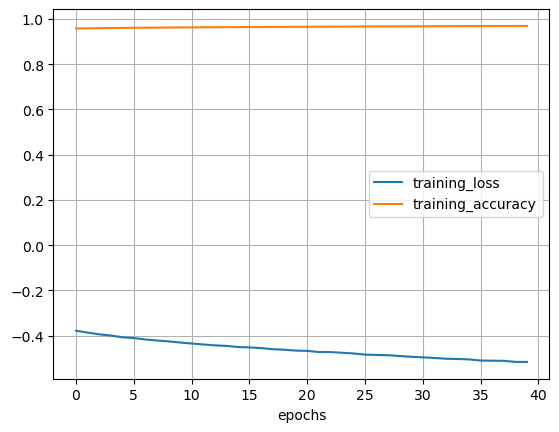

In [16]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')

Text(0, 0.5, 'IoU Score')

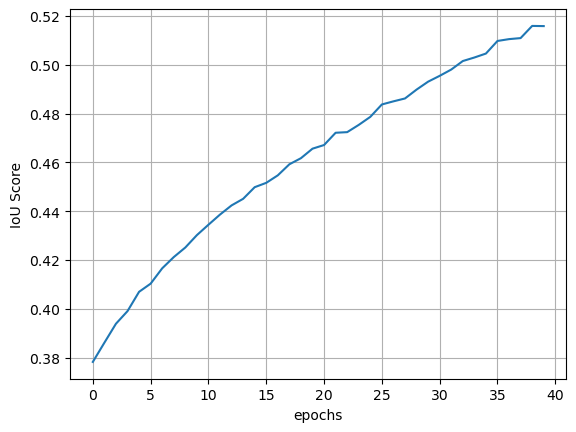

In [17]:
plt.plot(retVal.history['IoU'])
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('IoU Score') 

In [69]:
def predict(Map, model, shape = 128):
    img = Map['img'][0:100]
    if Map['mask'] is not None:
        mask = Map['mask'][0:100]
    
    imgProc = np.array(img)
    display.update()
    predictions = model.predict(imgProc)
  
    if Map['mask'] is None:
        return predictions, imgProc
    else:
        return predictions,imgProc,mask




obj={"img":[],"mask":None}      
def readtests( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    lis=[]
    for x in imgNames:
        lis.append(x)
    
    for i in range (len(imgNames)):
        display.update()
        img = plt.imread(imgPath + '/' +lis[i]) 
        img = cv2.resize(img, (shape, shape))
        frameObj['img'].append(img)
        
    return frameObj        
    

In [10]:
display=Tk()
predictions, actuals,masks = predict(frameobjtrain, unet)

4/4 [==============================] - 4s 433ms/step


In [ ]:


display=Tk()
display.title("Road_segmentator")
display.minsize(width=1100,height=500)

l1=Label(display,text="Roadscape: Geospatial Intelligence for Road Network Extraction!",fg="purple",bg="lightblue",font=("Times 20 bold"))
l1.pack()

l2=Label(display,text="->Select an image to inspect from test images",fg="black",font=("ms serif",18))
l2.place(x=20,y=50)

l3=Label(display,text="->Input the folder name to inspect custom images",fg="black",font=("ms serif",18))
l3.place(x=800,y=50)


def on_selection(event):
    selected_index = listbox1.curselection()
    if selected_index:
        selected_option = listbox1.get(selected_index)
        func1(selected_option)

listbox1= Listbox(display, selectmode=SINGLE, height=5)
listbox1.place(x=40,y=90)

for option in range(1,100):
    listbox1.insert(END, "image "+str(option))

listbox1.bind("<<ListboxSelect>>", on_selection)
#.....................................................................
def selection(event):
    selected_index = listbox2.curselection()
    if selected_index:
        selected_option = listbox2.get(selected_index)
        func2(selected_option)

listbox2= Listbox(display, selectmode=SINGLE, height=5)
listbox2.place(x=820,y=210)

for option in range(1,100):
    listbox2.insert(END, "image "+str(option))

listbox2.bind("<<ListboxSelect>>", selection)


x=StringVar()
e2=Entry(display,font=("times new roman",20),textvariable=x)
e2.place(x=800,y=80)

l4=Label(display,text="->Select an image to inspect from custom images",fg="black",font=("ms serif",18))
l4.place(x=800,y=170)


def func1(option):
    y=option.split()[1]
    x=int(y)-1
    
    fig, axs = plt.subplots(1, 3) 
    img = actuals[x]  
    mask = masks[x]
    pred =predictions[x]
    
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(pred)
    axs[1].set_title("predicted image")
    axs[2].imshow(mask)
    axs[2].set_title("mask")

    canvas = FigureCanvasTkAgg(fig, master=display)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.place(x=100,y=200)

def read():
    loading_window = Toplevel(display)
    loading_window.title("reading...")
    
    progress = ttk.Progressbar(loading_window, mode="indeterminate")
    progress.pack(padx=20, pady=20)
    progress.start()
   
    try:
        p=str(x.get())
        global obj
        obj=readtests(obj,imgPath='C:/Users/DELL/Downloads/'+p)
    except:
        messagebox.showwarning("caution","folder does not exist!")
        
        
    loading_window.destroy()
    s=Toplevel(display)
    l1=ttk.Label(s,text="success")
    l1.pack()

def delete():
    global obj
    obj['img']=[]
    global predtests
    predtests=[]
    global tests
    tests=[]
    
    
def predict1():
    loading_window = Toplevel(display)
    loading_window.title("predicting...")
    
    progress = ttk.Progressbar(loading_window, mode="indeterminate")
    progress.pack(padx=20, pady=20)
    progress.start()
   
    global predtests
    global tests
    predtests, tests = predict(obj, unet)    
   
    loading_window.destroy()
    s=Toplevel(display)
    l1=ttk.Label(s,text="success")
    l1.pack()
    
    
def func2(option):
    y=option.split()[1]
    x=int(y)-1
      
    pred = predtests[x]  
    img = tests[x]
    fig, axs = plt.subplots(1, 2) 
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(pred)
    axs[1].set_title("predicted image")

    
    canvas = FigureCanvasTkAgg(fig, master=display)
    canvas_widget = canvas.get_tk_widget()

    canvas_widget.place(x=100,y=200)   

    

b2=Button(display,text="read",font=("sans 12 bold"),fg="dark slate gray",bg="blanched almond",command=read)
b2.place(x=800,y=120)
b4=Button(display,text="predict",font=("sans 12 bold"),fg="dark slate gray",bg="blanched almond",command=predict1)
b4.place(x=850,y=120)
b5=Button(display,text="refresh",font=("sans 12 bold"),fg="dark slate gray",bg="blanched almond",command=delete)
b5.place(x=920,y=120)
display.mainloop()

In [49]:
print(type(obj["img"]))

KeyError: 'img'